# Making figure 8 of the paper
30/08/2023

In [6]:
import bagpipes as pipes
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

plt.rcParams.update({'font.size': 16})
import seaborn as sns
import os
from bagpipes import plotting
pipes.plotting.update_rcParams()
matplotlib.rcParams["axes.linewidth"] = 1.0

In [4]:
# change working directory to one layer above
os.chdir('..')
# set saving direction
save_dir = 'plots/'

In [39]:
# load in posterior samples and percentiles files
post_df = pd.read_csv('../data/posterior_samples.csv')
percentiles = pd.read_csv('../data/posterior_percentiles.csv')

In [40]:
# remove PSBs with bad GP noise fits
percentiles_ = percentiles[percentiles['GPnoise_flag']==0]

In [9]:
ylabels = {
    "age": "$\\mathrm{Age}/\\mathrm{Gyr}$",
    "tau": "$\\tau/\\mathrm{Gyr}$",
    "alpha1": "$\\alpha_1$",
    "burstage": "$\\mathrm{Burst\\ Age}\\ /\\ \\mathrm{Gyr}$",
    "alpha2": "$\\alpha_2$",
    "alpha": "$\\alpha$",
    "halftime": "Half time $\\tau_{1/2}\\ /\\ \\mathrm{Gyr}$",
    "fburst" : "Burst mass fraction",
    "massformed": "mass formed / $\\mathrm{log_{10}(M_*/M_{\\odot})}$",
    "stellar_mass": "stellar mass / $\\mathrm{log_{10}(M_*/M_{\\odot})}$",
    "redshift": "Redshift",
    "veldisp": "$\\sigma_{vel}$",
    "sfr": "$\\mathrm{SFR}\\mathrm{M_\\odot\\ yr}^{-1}$",
    "ssfr": "$\\mathrm{log_{10}(sSFR\\mathrm{yr}^{-1})}$",
    "metallicity_old": "$Z_\\mathrm{old}/Z_{\\odot}$",
    "metallicity_burst": "$Z_\\mathrm{burst}/Z_{\\odot}$",
    "metallicity_slope": "$Z_\\mathrm{slope}/Z_{\\odot}\\ Gyr^{-1}$",
    "metallicity": "metallicity / $Z_*/Z_{\\odot}$",
    "metallicity_diff": "Metallicity change / $(Z_\\mathrm{burst} - Z_\\mathrm{old})/Z_{\\odot}$",
    "MW_zmet": "$Z_\\mathrm{*,M}/Z_{\\odot}$",
    "log_MW_zmet_diff": "$\\log(Z_\\mathrm{*,M}/Z_{\\odot}) - \\log(Z_\\mathrm{old}/Z_{\\odot})$",
    "log_metallicity_old": "Pre-burst metallicity $\\log(Z_\\mathrm{old}/Z_{\\odot})$",
    "log_metallicity_burst": "Post-burst metallicity $\\log(Z_\\mathrm{burst}/Z_{\\odot})$",
    "log_zmet_diff": "$\\log_{10}(Z_\\mathrm{burst}/Z_\\odot) - \\log_{10}(Z_\\mathrm{old}/Z_\\odot)$",
    "f1.0": "M(1.0Gyr) / M(total)",
    "f1.5": "M(1.5Gyr) / M(total)",
    "tquench_from_1": "quenching timescale $\\tau_{q2}\\ /\\ \\mathrm{Gyr}$",
    "tquench_from_peak": "quenching timescale $\\tau_{q1}\\ /\\ \\mathrm{Gyr}$",
    "Av": "$\\mathrm{A_V}$",
    "eta": "$\eta_{\\mathrm{dust}}$",
    "NSA_Mstar": r'$\log_{10}M_*$ (NSA, whole galaxy)',
}

In [44]:
def get_split_ind(percentiles, parameter, split_func1, split_func2):
    """
    percentiles: the big df with the _16, _50 and _84 columns for each parameter
    parameter: the parameter to split on, auto assume it is the _50 column
    split_func1: the splitting function for group 1
    split_func2: the splitting function for group 2
    """
    
    group1_ind = []
    group2_ind = []
    count = 0
    for i,row in percentiles.iterrows():
        if split_func1(row[parameter+'_50']):
            group1_ind.append(count)
        elif split_func2(row[parameter+'_50']):
            group2_ind.append(count)
        count += 1
    
    return group1_ind, group2_ind

def comparison_plot(percentiles, Ngal, param1, param2, Nbins=15, 
                    figsize=[8,8], gs=None, fig=None, side_hist=True, errorbar=True, recent_burst=False, 
                    low_fburst=False,
                    low_fburst_light=False,
                    contour=False, post_samps=None, contour_levels=[0.5], logx=False, logy=False):
    """
    percentiles: the big df with the _16, _50 and _84 columns for each parameter
    Ngal: number of galaxies
    param1: the x axis parameter plotted
    param2: the y axis parameter plotted
    Nbins: Number of bins in the side histograms
    figsize: pyplot figsize, only used when gs is not passed
    gs: the gridspec to create the plot in, if passed, will not create a new figure but instead uses passed gs
    fig: the figure gs lives in
    side_hist: If True, make the side histograms
    #### Errors
    post_samps: big df with all individual posterior draws
    errorbar: If True, add errorbars to the dots
    contour: If True, draw contour lines that encases x% of marginalized posterior volume for each galaxy
    contour_levels: List of density levels to trace
    #### colour splitting
    recent_burst: If True, split colours by recent or not recent burst
    low_fburst: If True, split colours by high or low burst mass fraction
    low_fburst_light: If True, split colours by high or low burst light fraction
    #### ax_scale
    logx: log the x
    logy: log the y
    """
    
    # colours, markers and legend labels
    marker1 = 'o'
    marker2 = '^'
    
    if recent_burst:
        colour1 = 'tomato'
        colour2 = 'dodgerblue'
        label1 = '$t_\\mathrm{burst} \\ge 1$ Gyr'
        label2 = '$t_\\mathrm{burst} < 1$ Gyr'
        
    elif low_fburst:
        colour1 = 'magenta'
        colour2 = 'seagreen'#'gray'
        label1 = '$f_\\mathrm{burst} < 0.7$'
        label2 = '$f_\\mathrm{burst} \ge 0.7$'
        
    elif low_fburst_light:
        colour1 = 'magenta'
        colour2 = 'seagreen'#'gray'
        label1 = '$f_\\mathrm{burst,L} < 0.9$'
        label2 = '$f_\\mathrm{burst,L} \ge 0.9$'
    
    # picking out the right galaxies in this setting choice
    plateifu_list = list(percentiles['plateifu'])
    
    # split the table into the two colour groups, by sorting indices
    if recent_burst:
        group1_ind, group2_ind = get_split_ind(
            percentiles, 'burstage', lambda x: x >= 1.0, lambda x: x < 1.0
        )
        
    elif low_fburst:
        group1_ind, group2_ind = get_split_ind(
            percentiles, 'fburst', lambda x: x < 0.7, lambda x: x >= 0.7
        )
                
    elif low_fburst_light:
        group1_ind, group2_ind = get_split_ind(
            percentiles, 'fburst_light', lambda x: x < 0.9, lambda x: x >= 0.9
        )
        
    else:
        group1_ind = np.arange(Ngal)
        group2_ind = []
            
    # sorting out percentiles into right galaxies
    p1_percentiles = percentiles[[f'{param1}_16', f'{param1}_50', f'{param1}_84']].to_numpy().T
    p2_percentiles = percentiles[[f'{param2}_16', f'{param2}_50', f'{param1}_84']].to_numpy().T
        
    # making figure and axes
    if side_hist:
        if gs is None:
            fig = plt.figure(figsize=figsize)
            this_gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                              left=0.1, right=0.9, bottom=0.1, top=0.9,
                              wspace=0.05, hspace=0.05)
        else:
            this_gs = gs.subgridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                              wspace=0.05, hspace=0.05)
        ax = fig.add_subplot(this_gs[1, 0])
        ax_histx = fig.add_subplot(this_gs[0, 0], sharex=ax)
        ax_histy = fig.add_subplot(this_gs[1, 1], sharey=ax)
        axes_list = [ax,ax_histx,ax_histy]
        
    else:
        if gs is None:
            fig,ax = plt.subplots(figsize=figsize)
        else:
            ax = plt.subplot(gs)
        axes_list = [ax]
    
    # central dots scatter plot
    if recent_burst or low_fburst or low_fburst_light:
        # if split in colours
        ax.scatter(p1_percentiles[1][group1_ind], p2_percentiles[1][group1_ind], 
                   color=colour1, marker=marker1, s=50, zorder=1, label=label1)
        ax.scatter(p1_percentiles[1][group2_ind], p2_percentiles[1][group2_ind], 
                   color=colour2, marker=marker2, s=50, zorder=1, label=label2)
    else:
        # if not split in colours
        ax.scatter(p1_percentiles[1], p2_percentiles[1], 
                   color=colour1, marker=marker1, s=50, zorder=1)
    
    # errorbars
    if errorbar:
        if recent_burst or low_fburst or low_fburst_light:
            # if split in colours
            ax.errorbar(p1_percentiles[1][group1_ind], p2_percentiles[1][group1_ind], 
                        xerr=[p1_percentiles[1][group1_ind]-p1_percentiles[0][group1_ind], 
                              p1_percentiles[2][group1_ind]-p1_percentiles[1][group1_ind]],
                        yerr=[p2_percentiles[1][group1_ind]-p2_percentiles[0][group1_ind], 
                              p2_percentiles[2][group1_ind]-p2_percentiles[1][group1_ind]],
                           color=colour1, fmt='.', zorder=-1, alpha=0.7)
            ax.errorbar(p1_percentiles[1][group2_ind], p2_percentiles[1][group2_ind], 
                        xerr=[p1_percentiles[1][group2_ind]-p1_percentiles[0][group2_ind], 
                              p1_percentiles[2][group2_ind]-p1_percentiles[1][group2_ind]],
                        yerr=[p2_percentiles[1][group2_ind]-p2_percentiles[0][group2_ind], 
                              p2_percentiles[2][group2_ind]-p2_percentiles[1][group2_ind]],
                           color=colour2, fmt='.', zorder=-1, alpha=0.7)
        else:
            # if not split in colours
            ax.errorbar(p1_percentiles[1], p2_percentiles[1], 
                        xerr=[p1_percentiles[1]-p1_percentiles[0], 
                              p1_percentiles[2]-p1_percentiles[1]],
                        yerr=[p2_percentiles[1]-p2_percentiles[0], 
                              p2_percentiles[2]-p2_percentiles[1]],
                           color=colour1, fmt='.', zorder=-1, alpha=0.7)
    
    # contours from seaborn.kdeplot
    if contour:
        for j,plateifu in enumerate(plateifu_list):
            if j in group1_ind:
                this_colour = colour1
            elif j in group2_ind:
                this_colour = colour2
            this_post_df = post_samps[post_samps['plateifu']==plateifu]
            sns.kdeplot(data=this_post_df, x=param1, y=param2, levels=contour_levels, 
                        color=this_colour, alpha=0.5, ax=ax, zorder=-2)
    
    ax.set_xlabel(ylabels[param1])
    ax.set_ylabel(ylabels[param2])
    
    # side histograms
    if side_hist:
        ax_histx.tick_params(axis="x", labelbottom=False)
        ax_histy.tick_params(axis="y", labelleft=False)
        # get bin limits
        if logx:
            # deal with log quantity
            binsx = 10**np.linspace(np.log10(min(p1_percentiles[1])), np.log10(max(p1_percentiles[1])), Nbins)
            histx, _ = np.histogram(p1_percentiles[1], bins=binsx)
        else:
            histx, binsx = np.histogram(p1_percentiles[1], bins=Nbins)

        if logy:
            binsy = 10**np.linspace(np.log10(min(p2_percentiles[1])), np.log10(max(p2_percentiles[1])), Nbins)
            histy, _ = np.histogram(p2_percentiles[1], bins=binsy)
        else:
            histy, binsy = np.histogram(p2_percentiles[1], bins=Nbins)

        if recent_burst or low_fburst or low_fburst_light:
            ax_histx.hist(p1_percentiles[1][group1_ind],
                          bins=binsx, color=colour1, stacked=False,
                          alpha=0.3)
            ax_histx.hist(p1_percentiles[1][group2_ind],
                          bins=binsx, color=colour2, stacked=False,
                          alpha=0.3)
            # make the outlines on the hists
            hx1, edgesx1 = np.histogram(p1_percentiles[1][group1_ind], bins=binsx)
            ax_histx.stairs(hx1, edgesx1, color=colour1)
            hx2, edgesx2 = np.histogram(p1_percentiles[1][group2_ind], bins=binsx)
            ax_histx.stairs(hx2, edgesx2, color=colour2)

            ax_histy.hist(p2_percentiles[1][group1_ind],
                          bins=binsy, color=colour1, stacked=False,
                          alpha=0.3, orientation='horizontal')
            ax_histy.hist(p2_percentiles[1][group2_ind],
                          bins=binsy, color=colour2, stacked=False,
                          alpha=0.3, orientation='horizontal')
            # make the outlines on the hists
            hy1, edgesy1 = np.histogram(p2_percentiles[1][group1_ind], bins=binsy)
            ax_histy.stairs(hy1, edgesy1, color=colour1, orientation='horizontal')
            hy2, edgesy2 = np.histogram(p2_percentiles[1][group2_ind], bins=binsy)
            ax_histy.stairs(hy2, edgesy2, color=colour2, orientation='horizontal')

        else:
            ax_histx.hist(p1_percentiles[1], bins=binsx, color=colour1, alpha=0.5)
            ax_histy.hist(p2_percentiles[1], bins=binsy, color=colour1, alpha=0.5,
                          orientation='horizontal')
        
    return fig, axes_list

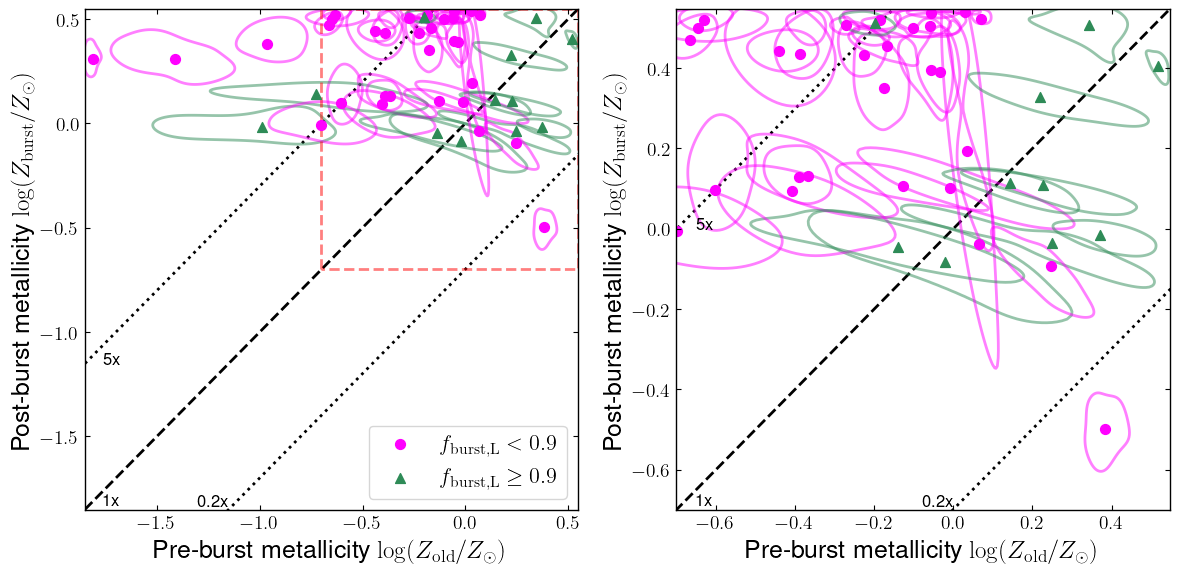

In [46]:
### plotting the plot
# parameter and limits
xparam = 'log_metallicity_old'
yparam = 'log_metallicity_burst'
# limits adjusted from bagpipes Zsun=0.02 to Zsun=0.0142 scale
xlims = [np.log10(0.01*0.02/0.0142),np.log10(2.5*0.02/0.0142)]
ylims = [np.log10(0.01*0.02/0.0142),np.log10(2.5*0.02/0.0142)]
zoom = -0.7
Ngal = len(percentiles_)

# make the figure
fig = plt.figure(figsize=[14,6.5])
gs = fig.add_gridspec(1,2, wspace=0.2, hspace=0.15)

# loop through the two panels
for i in range(2):
    
    if i==0:
        # include all galaxies if left panel
        p_df = percentiles_.copy()
        Ngal_ = Ngal
    elif i==1:
        # exclude those outside zoom limit if right panel
        p_df = percentiles_[percentiles_['log_metallicity_old_50']>zoom]
        Ngal_ = len(p_df.index)
        
    # make the dots and contours/errorbars in the plots
    fig, ax_list = comparison_plot(p_df, Ngal_, xparam, yparam, 
                                   low_fburst_light=True, gs=gs[i], fig=fig,
                                   errorbar=False, contour=True, post_samps=post_df,
                                   contour_levels=[1-0.393], side_hist=False
                                  )
    [ax] = ax_list
    
    # add the 5x, 1x and 0.2x lines
    log5 = np.log10(5)
    ax.plot([-2,1],[-2,1], 'k--', zorder=-5)
    ax.plot([-2,1],[-2+log5,1+log5], 'k:', zorder=-5)
    ax.plot([-2,1],[-2-log5,1-log5], 'k:', zorder=-5)
    
    # line labels, axis limits and legend
    if i==0:
        ax.text(xlims[0]+0.09,ylims[0]+0.02, '1x', fontsize=12)
        ax.text(xlims[0]+0.09,ylims[0]+log5, '5x', fontsize=12)
        ax.text(xlims[0]+log5,ylims[0]+0.02, '0.2x', fontsize=12, ha='right')
        
        ax.plot([-0.7,-0.7,xlims[1],xlims[1],-0.7], [-0.7,ylims[1],ylims[1],-0.7,-0.7], 
               color='r', alpha=0.5, ls='--', zorder=0)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.legend(loc='lower right', fontsize=16)
    else:
        ax.text(zoom+0.05,zoom+0.01, '1x', fontsize=12)
        ax.text(zoom+0.05,zoom+log5, '5x', fontsize=12)
        ax.text(zoom+log5,zoom+0.01, '0.2x', fontsize=12, ha='right')
        
        ax.set_xlim([zoom,xlims[1]])
        ax.set_ylim([zoom,ylims[1]])

plt.tight_layout()
plt.show()

In [47]:
fig.savefig(save_dir+'zmet_old_vs_zmet_burst_noselprop.pdf', bbox_inches='tight', dpi=150)